## Part 1

### Loading the datasets
#### 1. Confirmed URL : https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
#### 2. Deaths URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
#### 3. Recovered URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

#### Starting date on all three datasets is 22/01/2020

Steps (Without BeautifulSoup):-
1. Import the CSV 
2. Check if the last column title matches with the last date row in the cleaned dataset.
3. If it matches, don't add it to the dataset. 
4. If it does not match, go back iteratively until it matches and save all of the data.


In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [438]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

### Function to get the number of confirmed cases as a Dataframe

In [439]:
def get_confirmed():
    con_casesnew = pd.read_csv(confirmed_url)
    con_casesnew = con_casesnew.sum(axis=0)
    con_casesnew.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    con_casesnew = pd.DataFrame(con_casesnew)
    con_casesnew.rename(columns={0: "Infected"}, inplace=True)
    return con_casesnew

### Function to get the number of deaths as a Dataframe

In [440]:
def get_deaths():
    deaths_new = pd.read_csv(deaths_url)
    deaths_new = deaths_new.sum(axis=0)
    deaths_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    deaths_new = pd.DataFrame(deaths_new)
    deaths_new.rename(columns={0: "Deaths"}, inplace=True)
    return deaths_new

### Function to get the number of recoveries as a Dataframe

In [441]:
def get_recovered():
    rec_new = pd.read_csv(confirmed_url)
    rec_new = rec_new.sum(axis=0)
    rec_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    rec_new = pd.DataFrame(rec_new)
    rec_new.rename(columns={0: "Recovered"}, inplace=True)
    return rec_new

## Forecasting Confirmed Cases

In [442]:
df = get_confirmed()

In [443]:
df.tail()

,Infected
3/4/20,95123
3/5/20,97885
3/6/20,101799
3/7/20,105835
3/8/20,109836


In [444]:
close_data = df['Infected'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

In [454]:
look_back = 2

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [455]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 100
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100


ValueError: Error when checking input: expected lstm_29_input to have 3 dimensions, but got array with shape (20, 2)

In [ ]:
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [ ]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast = predict(num_prediction, model)

In [ ]:
forecast

In [ ]:
plt.plot(df)

In [456]:
df.tail()

,Infected
3/4/20,95123
3/5/20,97885
3/6/20,101799
3/7/20,105835
3/8/20,109836


In [457]:
forecast

array([109836, 3.53269624710083], dtype=object)

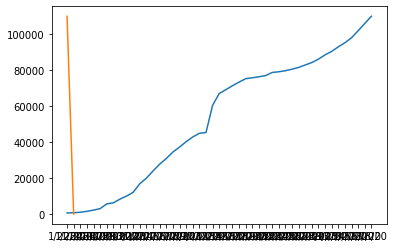

In [458]:
plt.plot(df)
plt.plot(forecast)